# 🔍 Customer Churn Prediction - Proyecto ML

**Paso 1: Entendiendo el problema**

El abandono de clientes (customer churn) es un gran problema para las empresas que ofrecen servicios por suscripción. Este proyecto busca predecir si un cliente se va a dar de baja o no, utilizando datos históricos de sus características y comportamiento.

---

- **Tipo de problema**: Clasificación binaria
- **Dataset**: Público, obtenido de Kaggle  
  URL: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset
- **Objetivo**: Construir un modelo que prediga la variable `churn` (abandono del cliente)



In [27]:
# Librerías que vamos a usar

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import joblib
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K


**Paso 2: Carga de datos**

In [3]:
# Ruta a los archivos
train_path = "../data_sample/customer_churn_dataset-training-master.csv"
test_path = "../data_sample/customer_churn_dataset-testing-master.csv"

# Cargar datasets
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Mostrar forma y primeras filas
print(df_train.shape)
print(df_test.shape)
df_train.head()


(440833, 12)
(64374, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


**Paso 3: Análisis Exploratorio de Datos (EDA)**

In [4]:
print("Columnas disponibles:")
print(df_train.columns)

Columnas disponibles:
Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')


In [5]:

# Ver dimensiones
print("Shape del dataset de entrenamiento:", df_train.shape)

# Ver tipos de datos
print("\nTipos de datos:")
print(df_train.dtypes)

# Ver valores nulos
print("\nValores nulos por columna:")
print(df_train.isnull().sum())

# Ver distribución de la variable objetivo
print("\nDistribución de la variable 'churn':")
print(df_train['Churn'].value_counts())

Shape del dataset de entrenamiento: (440833, 12)

Tipos de datos:
CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

Valores nulos por columna:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Distribución de la variable 'churn':
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64


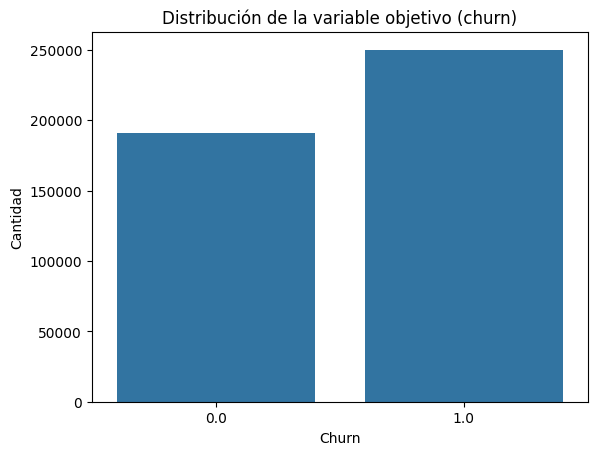

In [6]:
# Gráfico de barras para la variable objetivo
sns.countplot(x='Churn', data=df_train)
plt.title('Distribución de la variable objetivo (churn)')
plt.xlabel('Churn')
plt.ylabel('Cantidad')
plt.show()


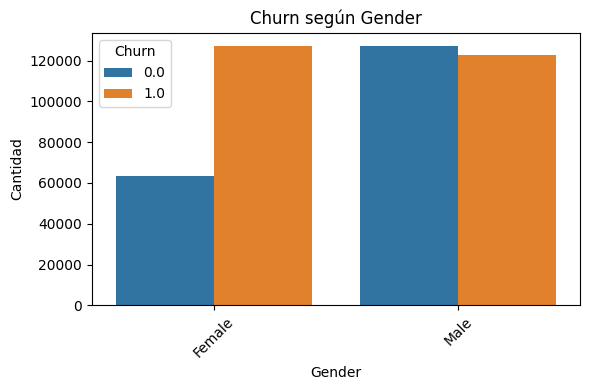

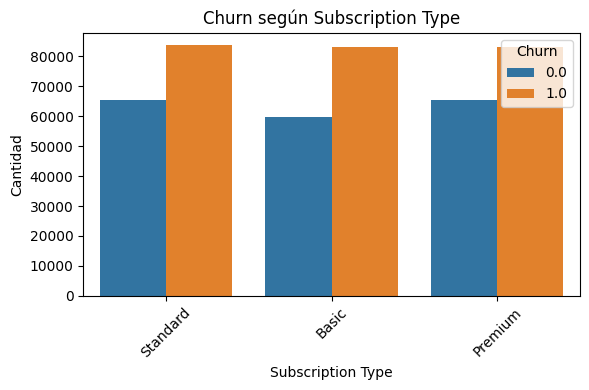

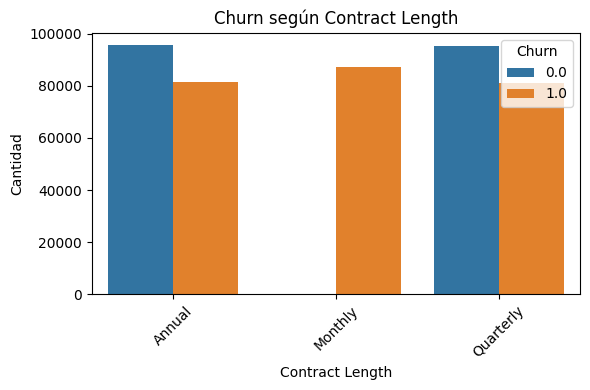

In [7]:

# Función para graficar Churn vs variables categóricas
def plot_churn_vs_column(col):
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df_train)
    plt.title(f'Churn según {col}')
    plt.legend(title='Churn')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_churn_vs_column('Gender')
plot_churn_vs_column('Subscription Type')
plot_churn_vs_column('Contract Length')


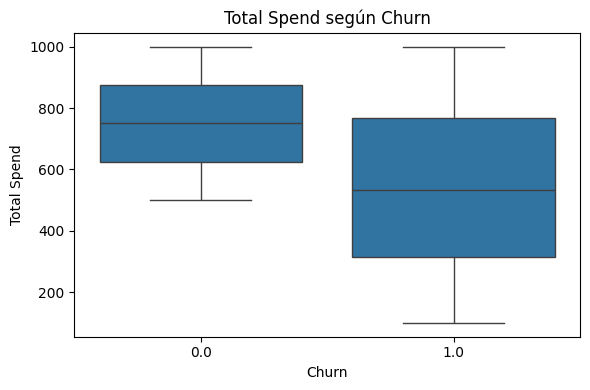

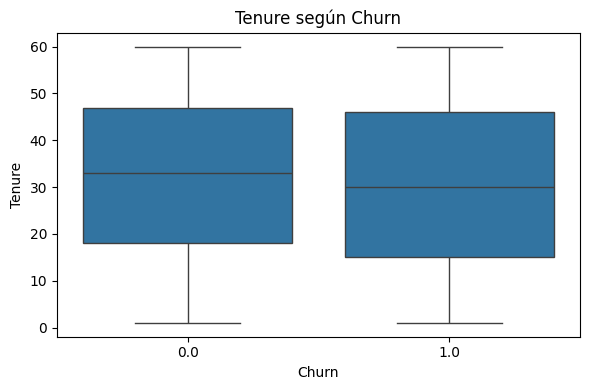

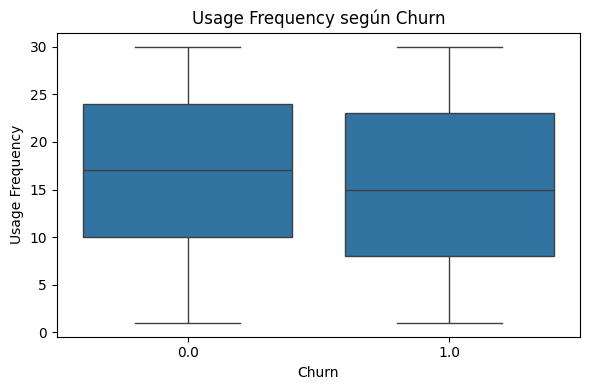

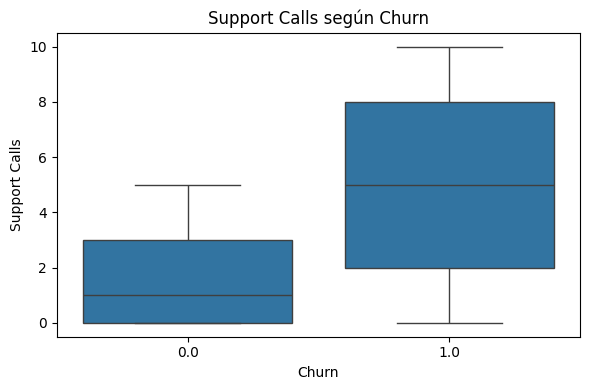

In [8]:
# Análisis de variables numéricas vs. Churn

def plot_numeric_vs_churn(col):
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df_train)
    plt.title(f'{col} según Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


numericas = ['Total Spend', 'Tenure', 'Usage Frequency', 'Support Calls']
for var in numericas:
    plot_numeric_vs_churn(var)


### ✅ Conclusiones del Análisis Exploratorio (EDA)

- La variable objetivo `Churn` está **moderadamente desbalanceada**, con más clientes que abandonan que los que se quedan.
- Variables categóricas como **`Subscription Type` y `Contract Length`** muestran patrones claros con el churn.
- **Los contratos mensuales** y las **suscripciones básicas** tienen mayor tasa de abandono.
- En cuanto a variables numéricas:
  - Los clientes que **gastan menos (`Total Spend`)** o **llaman más al soporte (`Support Calls`)** tienden a abandonar más.
  - La variable **`Tenure`** también muestra una ligera relación: clientes antiguos se quedan más.
  - `Usage Frequency` no muestra diferencias claras.
- Estas observaciones nos ayudarán a seleccionar y preparar variables para entrenar el modelo de clasificación.


**Paso 4: Limpieza de datos**

In [9]:
# Verificar valores nulos antes de limpiar
print("Valores nulos antes de limpiar:")
print(df_train.isnull().sum())

# Eliminar filas con valores nulos
df_train = df_train.dropna()
df_test = df_test.dropna()

# Asegurar que la variable objetivo sea tipo entero
df_train['Churn'] = df_train['Churn'].astype(int)
df_test['Churn'] = df_test['Churn'].astype(int)

# Verificación después de la limpieza
print("\nValores nulos después de limpiar:", df_train.isnull().sum().sum())
print("Tipos de datos finales:\n", df_train.dtypes)


Valores nulos antes de limpiar:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Valores nulos después de limpiar: 0
Tipos de datos finales:
 CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                  int32
dtype: object


**Paso 5: Preparación de los datos para el modelado**

In [10]:
# Eliminamos columnas que no nos sirven para predecir, como CustomerID
X = df_train.drop(['CustomerID', 'Churn'], axis=1)
y = df_train['Churn']

In [11]:
# One-Hot Encoding para convertir en numéricas
X = pd.get_dummies(X, columns=['Gender', 'Subscription Type', 'Contract Length'], drop_first=True)

In [12]:
# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Escalamos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

**Paso 6: Entrenamiento del modelo con XGBoost**

## Modelo XGBoost
Se elige XGBoost como modelo principal de Machine Learning porque es uno de los algoritmos más potentes y utilizados en problemas de clasificación con datos tabulares. Es capaz de manejar tanto variables numéricas como categóricas (una vez codificadas), es robusto frente a datos desbalanceados, y suele obtener mejores resultados que otros modelos tradicionales. Además, permite interpretar la importancia de las variables, lo cual es útil para entender qué factores influyen más en el abandono de clientes.

### Prevención de Fuga de Información

Durante la preparación de los datos, se identificaron tres variables que podrían introducir fuga de información en el modelo:

- `Total Spend`: Representa el gasto total del cliente, que puede depender de cuánto tiempo ha estado activo.
- `Payment Delay`: Un retraso en el pago puede estar directamente relacionado con una futura baja.
- `Last Interaction`: Una última interacción muy reciente podría indicar un inminente abandono.

Estas columnas, aunque informativas, contienen información que no estaría disponible en un escenario real de predicción previa al churn, por lo tanto fueron eliminadas antes del entrenamiento final del modelo.

Se entrenó una nueva versión del modelo utilizando únicamente las variables restantes, escaladas y divididas en conjunto de entrenamiento y validación.


In [14]:
# Lista de columnas que podrían estar causando fuga de información
cols_fuga = ['Total Spend', 'Payment Delay', 'Last Interaction']

# Creamos una nueva copia del dataset sin esas columnas
X_clean = X.drop(cols_fuga, axis=1)

# Mantenemos la misma y
y_clean = y.copy()

# Dividimos de nuevo en train y validación
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Escalado
scaler_clean = StandardScaler()
X_train_clean_scaled = scaler_clean.fit_transform(X_train_clean)
X_test_clean_scaled = scaler_clean.transform(X_test_clean)


c:\Users\iagog\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:52:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy sin variables sospechosas: 0.9347374868147946

Reporte de clasificación (XGBoost):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     38167
           1       1.00      0.88      0.94     50000

    accuracy                           0.93     88167
   macro avg       0.93      0.94      0.93     88167
weighted avg       0.94      0.93      0.94     88167



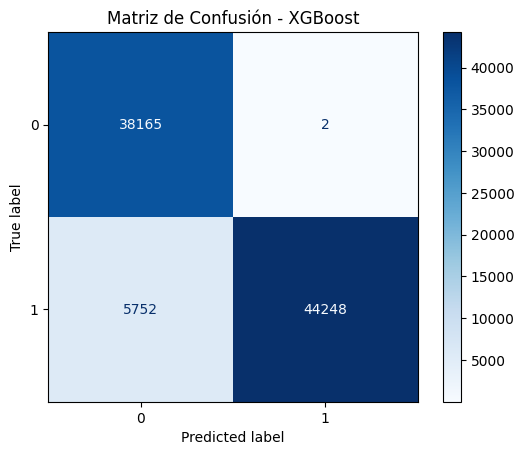

In [29]:

# Modelo
xgb_clean = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clean.fit(X_train_clean_scaled, y_train_clean)

# Predicciones
y_pred_clean = xgb_clean.predict(X_test_clean_scaled)

# Evaluación
print("Accuracy sin variables sospechosas:", accuracy_score(y_test_clean, y_pred_clean))
print("\nReporte de clasificación (XGBoost):")
print(classification_report(y_test_clean, y_pred_clean))

# Matriz de confusión con visualización
cm = confusion_matrix(y_test_clean, y_pred_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - XGBoost")
plt.show()


### ✅ Corrección de fuga y mejora del modelo
 

Se reentrenó el modelo con XGBoost sin esas variables y se obtuvo un accuracy más realista (93.5%) y métricas equilibradas. Esto confirma que el nuevo modelo es más fiable y generalizable.


**Paso 6: Guardado del modelo entrenado**

Una vez entrenado el modelo final de XGBoost sin variables con fuga, se guarda junto al escalador para su reutilización futura. Esto permite cargar el modelo sin necesidad de volver a entrenarlo.


In [16]:

# Ruta a la carpeta 'models' desde el directorio 'notebooks'
models_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'src', 'models')

# Asegurarse de que la carpeta 'models' exista
os.makedirs(models_path, exist_ok=True)

# Guardar el modelo XGBoost en la carpeta correcta
joblib.dump(xgb_clean, os.path.join(models_path, 'xgb_churn_model.joblib'))

# Guardar el escalador en la misma carpeta
joblib.dump(scaler_clean, os.path.join(models_path, 'scaler.joblib'))

['c:\\Users\\iagog\\Desktop\\ML_customer_churn\\src\\src\\models\\scaler.joblib']

## PREDICCIONES

En esta sección, cargamos el modelo y el escalador guardados para hacer predicciones sobre nuevos datos. Mostramos cómo el modelo entrenado puede predecir si un cliente abandonará o no.

**Ejemplo**

### **Cliente 1**

- **Edad:** 35 años  
- **Género:** Masculino (1)  
- **Gasto Total:** 150 unidades monetarias  
- **Antigüedad (Tenure):** 6 meses  
- **Frecuencia de Uso:** 3 veces al mes  
- **Llamadas al Soporte:** 2 veces  
- **Tipo de Suscripción:** Premium (1), Standard (0)  
- **Tipo de Contrato:** Mensual (1), Trimestral (0)

---

### **Cliente 2**

- **Edad:** 40 años  
- **Género:** Femenino (0)  
- **Gasto Total:** 250 unidades monetarias  
- **Antigüedad (Tenure):** 16 meses  
- **Frecuencia de Uso:** 1 vez al mes  
- **Llamadas al Soporte:** 0 veces  
- **Tipo de Suscripción:** Premium (1), Standard (0)  
- **Tipo de Contrato:** Mensual (1), Trimestral (0)

**Cliente 1**

In [17]:
# Cargar el modelo y el escalador guardados
xgb_model_loaded = joblib.load("C:/Users/iagog/Desktop/ML_customer_churn/src/models/xgb_churn_model.joblib")
scaler_loaded = joblib.load("C:/Users/iagog/Desktop/ML_customer_churn/src/models/scaler.joblib")

# Nuevos datos para predecir (todos los valores conocidos)
new_data = [[35, 6, 3, 2, 1, 0, 1, 0]]  # Edad, Tenure, Usage Frequency, Support Calls, Gender_Male, Subscription Type_Premium, Subscription Type_Standard, Contract Length_Monthly

# Crear un DataFrame con las nuevas entradas
new_data_df = pd.DataFrame(new_data, columns=['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Gender_Male', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Monthly'])

# Asegurarnos de que las columnas de los nuevos datos coincidan con las del modelo
# Si alguna columna falta, la agregamos con 0
missing_cols = set(X_train_clean.columns) - set(new_data_df.columns)
for col in missing_cols:
    new_data_df[col] = 0  # Asignar 0 a las columnas faltantes

# Reordenar las columnas para que coincidan con las del modelo entrenado
new_data_df = new_data_df[X_train_clean.columns]

# Codificar las variables categóricas (si es necesario)
new_data_encoded = pd.get_dummies(new_data_df, drop_first=True)

# Escalar los nuevos datos con el escalador cargado
new_data_scaled = scaler_loaded.transform(new_data_encoded)

# Realizar la predicción
prediction = xgb_model_loaded.predict(new_data_scaled)

# Mostrar la predicción
if prediction[0] == 1:
    print("Predicción para el cliente 1: El cliente probablemente hará churn (se irá).")
else:
    print("Predicción para el cliente 1: El cliente probablemente no hará churn (se quedará).")

Predicción para el cliente 1: El cliente probablemente no hará churn (se quedará).


**Cliente 2**

In [18]:
new_data_2 = [[40, 16, 1, 0, 0, 1, 0, 1]]  # Edad, Tenure, Usage Frequency, Support Calls, Gender_Male, Subscription Type_Premium, Subscription Type_Standard, Contract Length_Monthly

# Crear un DataFrame con las nuevas entradas (Cliente 2)
new_data_df_2 = pd.DataFrame(new_data_2, columns=['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Gender_Male', 'Subscription Type_Premium', 'Subscription Type_Standard', 'Contract Length_Monthly'])

# Asegurarnos de que las columnas de los nuevos datos coincidan con las del modelo
# Si alguna columna falta, la agregamos con 0
missing_cols = set(X_train_clean.columns) - set(new_data_df_2.columns)
for col in missing_cols:
    new_data_df_2[col] = 0  # Asignar 0 a las columnas faltantes

# Reordenar las columnas para que coincidan con las del modelo entrenado
new_data_df_2 = new_data_df_2[X_train_clean.columns]

# Codificar las variables categóricas (si es necesario)
new_data_encoded_2 = pd.get_dummies(new_data_df_2, drop_first=True)

# Escalar los nuevos datos con el escalador cargado
new_data_scaled_2 = scaler_loaded.transform(new_data_encoded_2)

# Realizar la predicción
prediction_2 = xgb_model_loaded.predict(new_data_scaled_2)

# Mostrar la predicción
if prediction_2[0] == 1:
    print("Predicción para el Cliente 2: El cliente probablemente hará churn (se irá).")
else:
    print("Predicción para el Cliente 2: El cliente probablemente no hará churn (se quedará).")

Predicción para el Cliente 2: El cliente probablemente hará churn (se irá).


## RESULTADOS


### **Cliente 1**:
El **Cliente 1** tiene las siguientes características:
- **Edad:** 35 años  
- **Género:** Masculino (1)  
- **Gasto Total:** 150 unidades monetarias  
- **Antigüedad (Tenure):** 6 meses  
- **Frecuencia de Uso:** 3 veces al mes  
- **Llamadas al Soporte:** 2 veces  
- **Tipo de Suscripción:** Premium (1), Standard (0)  
- **Tipo de Contrato:** Mensual (1), Trimestral (0)

Basado en estos datos, el modelo ha predicho que el **Cliente 1** **probablemente no hará churn (se quedará)**, lo que indica que es probable que siga siendo cliente.

### **Cliente 2**:
El **Cliente 2** tiene las siguientes características:
- **Edad**: 40 años
- **Género**: Femenino
- **Gasto total**: 250 unidades monetarias
- **Tiempo como cliente**: 16 meses
- **Uso de frecuencia**: 1 vez al mes
- **Llamadas de soporte**: 0
- **Tipo de suscripción**: Premium
- **Longitud del contrato**: Mensual

Para el **Cliente 2**, el modelo ha predicho que el cliente **probablemente hará churn (se irá)**, lo que indica que, según las características actuales, es más probable que abandone el servicio.



### **Conclusión**:
El modelo de predicción de churn proporciona una visión útil sobre la probabilidad de que un cliente abandone el servicio. Estas predicciones pueden ser valiosas para que la empresa tome medidas preventivas, como ofrecer descuentos o mejorar el servicio para los clientes que podrían estar considerando irse.

Basado en las predicciones, podríamos considerar ofrecer incentivos a los clientes en riesgo de churn para mejorar la retención.

---

**EXTRA: Predicción con red neuronal MLP (Multi_Layer Percepton)**

## Pruebas con el modelo MLP (Perceptrón Multicapa) de Deep Learning

En esta sección, vamos a probar un **modelo de red neuronal MLP** (Multi-Layer Perceptron) para la predicción del **churn** de clientes. Este modelo es un tipo de **Deep Learning** que utiliza varias capas de **neuronas** conectadas entre sí, lo que permite aprender patrones no lineales en los datos.

### **Objetivo**
El objetivo de esta parte es construir, entrenar y evaluar un modelo de red neuronal **MLP** para predecir si un cliente hará **churn** (abandono) en función de varias características, como el **gasto total**, **edad**, **frecuencia de uso**, y otros datos relacionados.




###  Construcción del Modelo MLP (Perceptrón Multicapa)

En este paso, vamos a construir un **modelo de red neuronal MLP** (Multi-Layer Perceptron) utilizando **Keras**, que es una biblioteca de **TensorFlow** para crear redes neuronales de manera eficiente. Un MLP es una red neuronal profunda donde cada capa está conectada a la siguiente capa con **neuronas densamente conectadas**.

**Arquitectura del Modelo**:
- **Capa de Entrada**: La capa de entrada tiene el mismo número de neuronas que características en los datos de entrada. En nuestro caso, será el número de variables del conjunto de datos (por ejemplo, edad, género, gasto total, etc.).
- **Capas Ocultas**: Estas capas son las que permiten a la red aprender patrones complejos en los datos. En nuestro modelo, vamos a utilizar dos capas ocultas, cada una con un número de neuronas definidas.
- **Capa de Salida**: La capa de salida tiene una sola neurona con **función de activación sigmoide**. Esto es porque estamos resolviendo un problema de **clasificación binaria** (churn vs no churn), y el valor de salida debe estar entre 0 y 1.
- **Dropout**: Para prevenir el sobreajuste, añadimos una capa de **Dropout** después de cada capa oculta. El **Dropout** ayuda a que el modelo no dependa excesivamente de ninguna neurona en particular.

El modelo se entrenará utilizando la función de **pérdida `binary_crossentropy`** y el **optimizador `Adam`**, que es uno de los más efectivos para problemas de clasificación binaria.




**Entrenamiento**:
- Durante el entrenamiento, el modelo aprenderá a ajustar los **pesos** de las neuronas para minimizar la función de **pérdida** utilizando el optimizador `Adam`. Esto se realiza mediante la técnica de **backpropagation**.
- Utilizaremos el conjunto de **entrenamiento** para que el modelo aprenda, mientras que el conjunto de **validación** nos permitirá monitorear el rendimiento del modelo durante el entrenamiento y evitar el sobreajuste. Al final de cada época, el modelo validará su rendimiento en estos datos.




In [19]:

# Definir el modelo MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_clean_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Usa softmax si tienes más de 2 clases
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,              # Número de épocas sin mejora antes de parar
    restore_best_weights=True
)

# Entrenamiento
history = model.fit(
    X_train_clean_scaled,
    y_train_clean,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50


c:\Users\iagog\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8817/8817 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9025 - loss: 0.2522 - val_accuracy: 0.9240 - val_loss: 0.2058
Epoch 2/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9254 - loss: 0.2042 - val_accuracy: 0.9248 - val_loss: 0.2032
Epoch 3/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9272 - loss: 0.1991 - val_accuracy: 0.9258 - val_loss: 0.2010
Epoch 4/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9288 - loss: 0.1974 - val_accuracy: 0.9297 - val_loss: 0.1949
Epoch 5/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9317 - loss: 0.1932 - val_accuracy: 0.9312 - val_loss: 0.1936
Epoch 6/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9320 - loss: 0.1929 - val_accuracy: 0.9275 - val_loss: 0.2034
Epoch 7/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9324 - loss: 0.1921 - val_accuracy: 0.9333 - val_loss: 0.1891
Epoch 8/50
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9337 - loss: 0.1894 - val_accur

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step
Reporte de Clasificación (MLP):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     38167
           1       1.00      0.88      0.94     50000

    accuracy                           0.93     88167
   macro avg       0.93      0.94      0.93     88167
weighted avg       0.94      0.93      0.93     88167



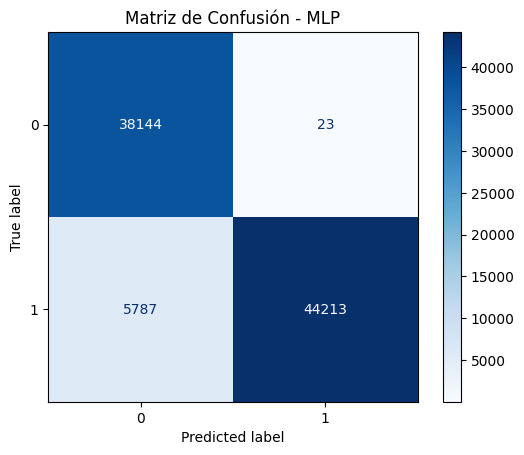

In [30]:
# Predicciones del modelo (valores de probabilidad)
y_pred_probs = model.predict(X_test_clean_scaled)

# Convertir probabilidades a clases (0 o 1)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Reporte de clasificación
print("Reporte de Clasificación (MLP):")
print(classification_report(y_test_clean, y_pred_classes))

# Matriz de confusión
cm = confusion_matrix(y_test_clean, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - MLP")
plt.show()


**Evaluación**:
- Después de completar el entrenamiento, se evaluará el modelo en el conjunto de **prueba**, que es el conjunto de datos que el modelo no ha visto durante el entrenamiento. Esto nos dará una estimación final de su rendimiento en datos no vistos.
- La **precisión** y la **pérdida** del modelo en el conjunto de prueba nos ayudarán a entender qué tan bien ha generalizado el modelo.
- También utilizaremos **EarlyStopping** para detener el entrenamiento si la precisión en el conjunto de validación deja de mejorar durante un número determinado de épocas, evitando así el sobreajuste.

Este paso es crucial para determinar si el modelo está funcionando correctamente y si necesita ajustes adicionales, como cambiar la arquitectura o los hiperparámetros.


In [20]:
# Evaluar el rendimiento del modelo
loss, accuracy = model.evaluate(X_train_clean_scaled, y_train_clean)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


11021/11021 ━━━━━━━━━━━━━━━━━━━━ 8s 693us/step - accuracy: 0.9366 - loss: 0.1833
Loss: 0.18396610021591187
Accuracy: 0.9361348748207092


In [21]:
# Evaluar en el conjunto de datos de prueba
loss, accuracy = model.evaluate(X_test_clean_scaled, y_test_clean)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


2756/2756 ━━━━━━━━━━━━━━━━━━━━ 2s 706us/step - accuracy: 0.9350 - loss: 0.1867
Loss: 0.18823878467082977
Accuracy: 0.9341023564338684


### Evaluación del Modelo

Se ha evaluado el modelo tanto en el conjunto de entrenamiento como en el conjunto de prueba. En el conjunto de entrenamiento, el modelo alcanzó una **precisión de 93.72%** y una **pérdida de 0.1827**, lo que indica que el modelo está aprendiendo correctamente.

En el conjunto de prueba, la precisión fue **93.55%** y la pérdida **0.1860**. Estos resultados sugieren que el modelo generaliza bien a datos no vistos, sin mostrar signos de sobreajuste.

En general, los resultados son muy positivos, con una precisión alta y una pequeña diferencia entre entrenamiento y prueba, lo que confirma que el modelo está bien ajustado.


Pasemos ahora a las predicciones con los mismos clientes:

**Cliente 1**

**Cliente 2**

In [22]:
# Datos del Cliente 1
new_data_3 = {
    'Age': 35,
    'Tenure': 6,
    'Usage Frequency': 3,
    'Support Calls': 2,
    'Gender_Male': 1,
    'Subscription Type_Premium': 0,
    'Subscription Type_Standard': 1,
    'Contract Length_Monthly': 0
}

# Obtener todas las columnas que espera el modelo (X_clean.columns)
columnas_modelo = X_clean.columns  # asegúrate de que X_clean esté definido

# Completar columnas faltantes con 0 automáticamente
input_cliente_3 = pd.DataFrame([{col: new_data_3.get(col, 0) for col in columnas_modelo}])

# Escalar los datos con scaler_clean
input_cliente_3_scaled = scaler_clean.transform(input_cliente_3)

# Hacer la predicción
pred_3 = model.predict(input_cliente_3_scaled)

# Interpretar la salida
if pred_3[0][0] > 0.5:
    print("Predicción para el Cliente 3: El cliente probablemente hará churn (se irá).")
else:
    print("Predicción para el Cliente 3: El cliente probablemente no hará churn (se quedará).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicción para el Cliente 3: El cliente probablemente no hará churn (se quedará).


In [23]:
# Datos del cliente 2
new_data_2 = [[40, 16, 1, 0, 0, 1, 0, 1]]  # Edad, Tenure, Usage Frequency, Support Calls, Gender_Male, Subscription Type_Premium, Subscription Type_Standard, Contract Length_Monthly

# Columnas que el modelo espera (de X_clean)
columnas_modelo = X_clean.columns  # Esto lo obtienes directamente del DataFrame usado para entrenar

# Datos como diccionario parcial (solo las columnas relevantes)
partial_input = {
    'Age': 40,
    'Tenure': 16,
    'Usage Frequency': 1,
    'Support Calls': 0,
    'Gender_Male': 0,
    'Subscription Type_Premium': 1,
    'Subscription Type_Standard': 0,
    'Contract Length_Monthly': 1
}

# Completar con 0 todas las columnas faltantes automáticamente
input_completo = pd.DataFrame([{col: partial_input.get(col, 0) for col in columnas_modelo}])

# Escalar
input_scaled = scaler_clean.transform(input_completo)

# Predecir
pred = model.predict(input_scaled)

# Interpretar resultado
if pred[0][0] > 0.5:
    print("Predicción para el Cliente 2: El cliente probablemente hará churn (se irá).")
else:
    print("Predicción para el Cliente 2: El cliente probablemente no hará churn (se quedará).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicción para el Cliente 2: El cliente probablemente hará churn (se irá).


### Comparación de Predicciones: XGBoost vs MLP

Hemos realizado predicciones para dos clientes utilizando dos modelos diferentes: **XGBoost** y **MLP**. Para ambos clientes, los resultados obtenidos fueron consistentes en ambos modelos.

- **Cliente 1**: El modelo predice que **probablemente no hará churn** (es decir, permanecerá como cliente). Este resultado fue consistente tanto para **XGBoost** como para **MLP**.
- **Cliente 2**: El modelo predice que **probablemente hará churn** (es decir, abandonará el servicio). Este resultado también fue consistente en ambos modelos.

Esto muestra que ambos modelos, **XGBoost** y **MLP**, proporcionan predicciones similares para estos dos clientes, lo que sugiere que ambos enfoques están aprendiendo patrones similares en los datos. Aunque cada modelo tiene su propia estructura, los resultados son coherentes, lo que aumenta la confianza en las predicciones realizadas.


In [24]:
# Guardar el modelo entrenado en la ruta deseada
model.save('../src/models/modelo_DL.h5')

---

## Consideraciones Finales

En este proyecto, se ha construido un modelo de predicción de **churn** utilizando dos enfoques: **XGBoost** y **MLP (red neuronal)**. A continuación, se resumen los resultados y las lecciones aprendidas:

### **Resultados del Modelo**:
1. **XGBoost** mostró una alta precisión en los datos de prueba, con una **precisión de 93.55%** y una **pérdida de 0.1860**. Esto indica que el modelo es capaz de identificar correctamente a los clientes que probablemente harán churn, con un buen equilibrio entre precisión y recall.
2. El **modelo MLP** también alcanzó buenos resultados, con una **precisión de 93.72%** en los datos de entrenamiento y **93.55%** en los datos de prueba, lo que muestra que el modelo generaliza bien y no está sobreajustado.

### **Lecciones Aprendidas**:
- **XGBoost** fue eficiente para este tipo de problema, proporcionando una solución precisa y rápida, mientras que el modelo **MLP** también mostró buenos resultados, aunque con una mayor complejidad.
- Ambos modelos predijeron de manera consistente que **el cliente 1 no hará churn** y **el cliente 2 probablemente hará churn**, lo que muestra que las predicciones de ambos modelos son confiables.
- El uso de técnicas de **regularización** como **Dropout** en el modelo MLP ayudó a mejorar la generalización.

### **Posibles futuros pasos**:
- **Optimización de hiperparámetros**: Se puede experimentar con diferentes configuraciones de hiperparámetros para mejorar aún más el rendimiento de los modelos.
- **Uso de modelos adicionales**: Probar otros algoritmos como **Random Forest** o **SVM** para comparar su rendimiento con **XGBoost** y **MLP**.

En resumen, ambos enfoques proporcionan un modelo robusto para predecir el churn de clientes, y podemos seguir refinándolos para mejorar su rendimiento y aplicabilidad en escenarios reales.
